## Demonstration for using *beamline* python module to do online modeling.
    
For example, define lattice configuration for a 4-dipole chicane with quads:
                    
                    |-|---|-|  
                    /       \
          ---||---|-|       |-|---||---

        i.e.   drift + quad  + drift 
            + dipole + drift + dipole + drift 
            + dipole + drift + dipole
            + drift  + quad  + drift

Below is the typical workflow:

In [1]:
import beamline
import os

#### STEP 1: define common information, two different input parameter formats

In [2]:
#commdinfo = {'DATE': '2016-03-22', 'AUTHOR': 'Tong Zhang'}
comminfo = 'DATE = 2016-03-24, AUTHOR = Tong Zhang'
beamline.MagBlock.setCommInfo(comminfo)

#### STEP 2: create elements

In [22]:
# charge
chconf = {'total':1e-9}
q = beamline.ElementCharge(name = 'q', config = chconf)

# csrcsben
simconf = {"edge1_effects": 1,
           "edge2_effects":1,
           "hgap":0.015,
           "csr":0,
           "nonlinear":1,
           "n_kicks":100,
           "integration_order":4,
           "bins":512,
           "sg_halfwidth":1,
           "block_csr":0,
           'l':0.5,}
angle = 0.1 # rad

B1 = beamline.ElementCsrcsben(name = 'b1', config = {'angle':angle, 'e1':0, 'e2':angle})
B1.setConf(simconf, type = 'simu')
    
B2 = beamline.ElementCsrcsben(name = 'b2', config = {'angle':-angle, 'e1':-angle, 'e2':0})
B3 = beamline.ElementCsrcsben(name = 'b3', config = {'angle':-angle, 'e1':0,      'e2':-angle})
B4 = beamline.ElementCsrcsben(name = 'b4', config = {'angle': angle, 'e1':angle,  'e2':0})
B2.setConf(simconf, type = 'simu')
B3.setConf(simconf, type = 'simu')
B4.setConf(simconf, type = 'simu')

# drift
D0 = beamline.ElementDrift(name = 'D0', config = "l=1.0")

# quad
Q1 = beamline.ElementQuad(name = 'Q1', config = "k1 = 10, l = 0.1")
simuconf = {'tilt':"pi 4 /"}
Q1.setConf(simuconf, type = 'simu')
# control configurations for Q1
ctrlconf = {"k1":{'pv':"sxfel:lattice:Q09",'val':''}}
Q1.setConf(ctrlconf, type = 'ctrl')
print Q1.dumpConfig(type='online')
#Q1.printConfig(type = 'simu')
Q1.printConfig(type = 'all')

{'Q1': {'QUAD': {'tilt': 'pi 4 /', 'k1': {'pv': 'sxfel:lattice:Q09', 'val': ''}, 'l': '0.1'}}}
---------- Configuration START  ----------
class name: ElementQuad
Common configs:
  DATE   = 2016-03-24
  AUTHOR = Tong Zhang
Simulation configs:
  tilt   = pi 4 /
  l      = 0.1   
  k1     = 10    
Control configs:
  k1     = sxfel:lattice:Q09, 1.0   
----------  Configuration END   ----------


#### STEP 3: make lattice beamline

In [4]:
# METHOD 1: CANNOT get all configurations
# use 'ElementBeamline' class of 'element' module
#
# beamline
latele = [obj.name for obj in [q, D0, Q1, D0, B1, D0, B2, D0, D0, B3, D0, B4, D0, Q1, D0]]
latstr = '(' + ' '.join(latele) + ')'
 
bl = beamline.ElementBeamline(name = 'bl', config = {'lattice':latstr})
#bl = beamline.ElementBeamline(name = 'bl1', config = "lattice = (q d0 q1)")
#bl.setConf("lattice = (d,q,b)", type = 'simu')
#print bl

# METHOD 2: CAN get all configurations
# use 'Models' class of 'models' module
latline_online = beamline.Models(name = 'blchi', mode = 'online')
qline = (D0, Q1, D0)
chi   = (B1, D0, B2, D0, D0, B3, D0, B4)
latline_online.addElement(q, qline, chi, qline)
#latline_online.getCtrlConf()
    
# show defined elements number
#print beamline.MagBlock.sumObjNum()

15

In [5]:
latline_online.getAllConfig(fmt='dict')['Q1']

{'QUAD': {'k1': 1.0, 'l': '0.1', 'tilt': 'pi 4 /'}}

In [6]:
qcharge = filter(lambda x:x.name == 'q', latline_online._lattice_eleobjlist)[0]
qcharge.setConf('total = 1e-9',type='simu')

In [7]:
eleb1 = latline_online.getElementsByName('b1')
latline_online.printAllElements()

ID : Name         Type       Class Name
001: q            CHARGE     ElementCharge
002: D0           DRIFT      ElementDrift
003: Q1           QUAD       ElementQuad
004: D0           DRIFT      ElementDrift
005: b1           CSRCSBEN   ElementCsrcsben
006: D0           DRIFT      ElementDrift
007: b2           CSRCSBEN   ElementCsrcsben
008: D0           DRIFT      ElementDrift
009: D0           DRIFT      ElementDrift
010: b3           CSRCSBEN   ElementCsrcsben
011: D0           DRIFT      ElementDrift
012: b4           CSRCSBEN   ElementCsrcsben
013: D0           DRIFT      ElementDrift
014: Q1           QUAD       ElementQuad
015: D0           DRIFT      ElementDrift


In [8]:
eleb1.setConf('angle = 0.1',type='simu')

In [9]:
eleQ1 = latline_online.getElementsByName('Q1')
eleQ1.printConfig(type='all')

---------- Configuration START  ----------
class name: ElementQuad
Common configs:
  DATE   = 2016-03-24
  AUTHOR = Tong Zhang
Simulation configs:
  tilt   = pi 4 /
  l      = 0.1   
  k1     = 10    
Control configs:
  k1     = sxfel:lattice:Q09, 1.0   
----------  Configuration END   ----------


In [10]:
latline_online.putCtrlConf(eleQ1, 'k1', 1)

True

In [11]:
latline_online.getAllConfig(fmt='dict')

{'B1': {'CSRCSBEN': {'angle': 0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': 0,
   'e2': 0.1,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015,
   'integration_order': 4,
   'l': 0.5,
   'n_kicks': 100,
   'nonlinear': 1,
   'sg_halfwidth': 1}},
 'B2': {'CSRCSBEN': {'angle': -0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': -0.1,
   'e2': 0,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015,
   'integration_order': 4,
   'l': 0.5,
   'n_kicks': 100,
   'nonlinear': 1,
   'sg_halfwidth': 1}},
 'B3': {'CSRCSBEN': {'angle': -0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': 0,
   'e2': -0.1,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015,
   'integration_order': 4,
   'l': 0.5,
   'n_kicks': 100,
   'nonlinear': 1,
   'sg_halfwidth': 1}},
 'B4': {'CSRCSBEN': {'angle': 0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': 0.1,
   'e2': 0,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015

#### STEP 4: create Lattice instance, make simulation required input files

In [12]:
# e.g. '.lte' for elegant tracking, require all configurations
latins = beamline.Lattice(latline_online.getAllConfig())
latfile = os.path.join(os.getcwd(), 'tracking/test.lte')
latins.generateLatticeFile(latline_online.name, latfile)

True

In [13]:
latins.dumpAllElements()

'{"Q1": {"QUAD": {"tilt": "pi 4 /", "k1": 1.0, "l": "0.1"}}, "B4": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": 0.1, "n_kicks": 100, "edge2_effects": 1, "edge1_effects": 1, "l": 0.5, "nonlinear": 1, "sg_halfwidth": 1, "csr": 0, "e1": 0.1, "bins": 512, "e2": 0}}, "Q": {"CHARGE": {"total": 1e-09}}, "BLCHI": {"BEAMLINE": {"lattice": "(q D0 Q1 D0 b1 D0 b2 D0 D0 b3 D0 b4 D0 Q1 D0)"}}, "B1": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": 0.1, "n_kicks": 100, "edge2_effects": 1, "edge1_effects": 1, "l": 0.5, "nonlinear": 1, "sg_halfwidth": 1, "csr": 0, "e1": 0, "bins": 512, "e2": 0.1}}, "B2": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": -0.1, "n_kicks": 100, "edge2_effects": 1, "edge1_effects": 1, "l": 0.5, "nonlinear": 1, "sg_halfwidth": 1, "csr": 0, "e1": -0.1, "bins": 512, "e2": 0}}, "B3": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": -0.1, "n_kicks": 100, "edge2

#### STEP 5: simulation with generated lattice file

In [14]:
simpath = os.path.join(os.getcwd(), 'tracking')
elefile = os.path.join(simpath, 'test.ele')
h5out   = os.path.join(simpath, 'tpout.h5')
elesim = beamline.Simulator()
elesim.setMode('elegant')
elesim.setScript('runElegant.sh')
elesim.setExec('elegant')
elesim.setPath(simpath)
elesim.setInputfiles(ltefile = latfile, elefile = elefile)


In [15]:
elesim.doSimulation()

In [16]:
# data columns could be extracted from simulation output files, to memory or h5 files.
data_tp    = elesim.getOutput(file = 'test.out', data = ('t', 'p'  ))#, dump = h5out)
data_sSx   = elesim.getOutput(file = 'test.sig', data = ('s', 'Sx' ))
data_setax = elesim.getOutput(file = 'test.twi', data = ('s', 'etax'))

#### visualize data

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

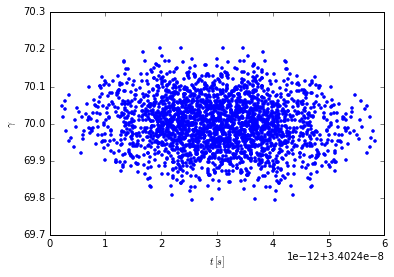

In [18]:
plt.plot(data_tp[:,0],data_tp[:,1],'.')
plt.xlabel('$t\,[s]$')
plt.ylabel('$\gamma$')

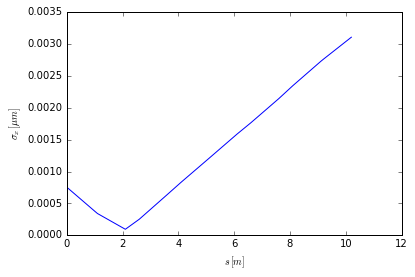

In [19]:
plt.plot(data_sSx[:,0],data_sSx[:,1],'-')
plt.ylabel('$\sigma_x\,[\mu m]$')
plt.xlabel('$s\,[m]$')

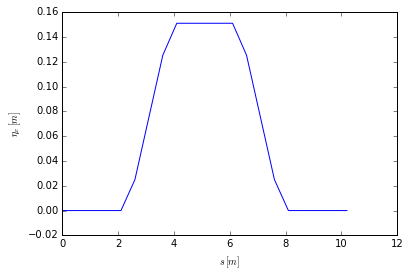

In [20]:
plt.plot(data_setax[:,0],data_setax[:,1],'-')
plt.ylabel('$\eta_{x}\,[m]$')
plt.xlabel('$s\,[m]$')